In [1]:
%%capture
import tensorflow as tf
from tensorflow import keras
from scipy.io import loadmat
from tensorflow.keras import regularizers
import os
import time
import numpy as np
import gc
import shutil
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import Input
from tensorflow.keras.models import model_from_json
from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from sklearn.metrics import r2_score
from sklearn import preprocessing

In [2]:
path_to_folder = "/home/pk2573/Capstone_Data"

## 1. Define Helper Functions 

In [3]:
def scale(x):
    """
    Scales the input data by subtracting the mean and dividing by the standard deviation 
    
    Inputs: x: a n-dimensional tensor
    
    Returns: a n-dimensional tensor of same shape as x
    """

    return (x - np.mean(x)) / np.std(x)

In [4]:
def preprocess(x):
    """
    Cuts the input 75% along the z-axis to remove laminar layers
    
    Inputs: x: a 3-dimensional tensor
    
    Returns: a 3-dimensional tensor of shape (length, width, 56)
    """
    
    return x[:,:,:int(0.75*x.shape[2])]

In [5]:
def create_boxes(x, tau_12, tau_13, tau_23, num_files, coarse_folder):
    """
    creates boxes of size 7x7x7x3
    
    Inputs: x: a 4-dimensional tensor
                tau_12: a 3-dimensional tensor
                tau_13: a 3-dimensional tensor
                tau_23: a 3-dimensional tensor
                num_files: # of files to save to disk 
                coarse_folder: coarse size to determine save location
    
    Returns: x: a tensor of shape (x.shape[0] * x.shape[1] * x.shape[2], 7, 7, 7, 3)
                  y_tau_12: a tensor of shape (tau_12.shape[0] * tau_12.shape[1] * tau_12.shape[2],)
                  y_tau_13: a tensor of shape (tau_13.shape[0] * tau_13.shape[1] * tau_13.shape[2],)
                  y_tau_23: a tensor of shape (tau_23.shape[0] * tau_23.shape[1] * tau_23.shape[2],)
    """
    sample = []
    y_tau_12 = []
    y_tau_13 = []
    y_tau_23 = []
    size = 3
    counter = 1
    
    x_range = np.arange(size, x.shape[0] - size)
    np.random.shuffle(x_range)
    y_range = np.arange(size, x.shape[1] - size)
    np.random.shuffle(y_range)
    z_range = np.arange(size, x.shape[2] - size)
    np.random.shuffle(z_range)
    
    for i in tqdm_notebook(x_range):
        for j in y_range:
            for k in z_range:
                sample.append(x[i - size: i + size + 1, j - size: j + size + 1, k - size: k + size + 1, :])
                y_tau_12.append(tau_12[i - size][j - size][k - size])
                y_tau_13.append(tau_13[i - size][j - size][k - size])
                y_tau_23.append(tau_23[i - size][j - size][k - size])
                
                if len(sample) == int(((x.shape[0] - size * 2) * (x.shape[1] - size * 2) * (x.shape[2] - size * 2)) / num_files):
                    os.chdir(path + "/Data_" + coarse_folder + "/Data")
                    np.save(str(counter), np.array(sample))
                    os.chdir(path + "/Data_" + coarse_folder + "/Labels")
                    np.save(str(counter), np.array([y_tau_12, y_tau_13, y_tau_23]))
                    
                    del sample
                    del y_tau_13
                    del y_tau_12
                    del y_tau_23
                    gc.collect()
                    sample = []
                    y_tau_23 = []
                    y_tau_12 = []
                    y_tau_13 = []
                    
                    counter += 1

## 2. Generate Datasets

In [6]:
path = os.path.dirname(path_to_folder)
for coarse_folder in os.listdir(path_to_folder + "/Re1243Fr20")[1:]:
    os.chdir(path_to_folder + "/Re1243Fr20/" + coarse_folder)
        
    # Load datasets
    u = loadmat('u_F_xyz_T1.mat')
    u = preprocess(scale(u[list(u.keys())[-1]]))
    v = loadmat('v_F_xyz_T1.mat')
    v = preprocess(scale(v[list(v.keys())[-1]]))
    w = loadmat('w_F_xyz_T1.mat')
    w = preprocess(scale(w[list(w.keys())[-1]]))
    tau_12 = loadmat('tau12_F_xyz_T1.mat')
    tau_12 = preprocess(scale(tau_12[list(tau_12.keys())[-1]]))
    tau_13 = loadmat('tau13_F_xyz_T1.mat')
    tau_13 = preprocess(scale(tau_13[list(tau_13.keys())[-1]]))
    tau_23 = loadmat('tau23_F_xyz_T1.mat')
    tau_23 = preprocess(scale(tau_23[list(tau_23.keys())[-1]]))
    x = np.array([u, v, w])
    x = np.transpose(x, [1, 2, 3, 0])
    x = np.pad(x, ((3,3), (3,3), (3,3), (0,0)), 'constant', constant_values = 0)
    
    # Create directories to save independent and dependent variables
    if not os.path.exists(path + "/Data_" + coarse_folder):
        os.mkdir(path + "/Data_" + coarse_folder)
        os.mkdir(path + "/Data_" + coarse_folder + "/Data")
        os.mkdir(path + "/Data_" + coarse_folder + "/Labels")
    else:
        shutil.rmtree(path + "/Data_" + coarse_folder)
        os.mkdir(path + "/Data_" + coarse_folder)
        os.mkdir(path + "/Data_" + coarse_folder + "/Data")
        os.mkdir(path + "/Data_" + coarse_folder + "/Labels")
        
     # Generate boxes and save to disk 
    create_boxes(x, tau_12, tau_13, tau_23, 25, coarse_folder)
    del u 
    del v
    del w
    del tau_12
    del tau_13
    del tau_23
    gc.collect()

## 3. Build Model

In [7]:
class DNN(object):
    
    def __init__(self, activation, initializer, regularizer, input_shape):
        self.activation = activation
        self.initializer = initializer
        self.regularizer = regularizer
        self.input_shape = input_shape
        
        pass 
    
    def create_model(self):
        """
        Creates functional keras model

        Inputs: self

        Returns: a sequential keras model with the parameters defined in __init__
        """
        
        data = Input(shape = self.input_shape, name = 'data')
        
        x = tf.keras.layers.Flatten()(data)
        x = tf.keras.layers.Dense(128, 
                                  activation = self.activation,
                                  kernel_regularizer = self.regularizer, 
                                  kernel_initializer = self.initializer)(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(64, 
                                  activation = self.activation,
                                  kernel_regularizer = self.regularizer, 
                                  kernel_initializer = self.initializer)(x)
        x = tf.keras.layers.Dropout(0.2)(x)
        x = tf.keras.layers.Dense(32, 
                                  activation = self.activation,
                                  kernel_regularizer = self.regularizer, 
                                  kernel_initializer = self.initializer)(x)

        tau_12 = tf.keras.layers.Dense(1, name = "tau_12")(x)
        tau_13 = tf.keras.layers.Dense(1, name = "tau_13")(x)
        tau_23 = tf.keras.layers.Dense(1, name = "tau_23")(x)
        
        model = Model(data, [tau_12, tau_13, tau_23])
        
        return model

## 4. Run model

Final Dataset Correlation for Tau_12: 0.9069
Final Dataset Correlation for Tau_13: 0.9058
Final Dataset Correlation for Tau_23: 0.9107
Saved model to disk

CPU times: user 3h 17min 54s, sys: 2h 20min 41s, total: 5h 38min 36s
Wall time: 4h 20min 56s


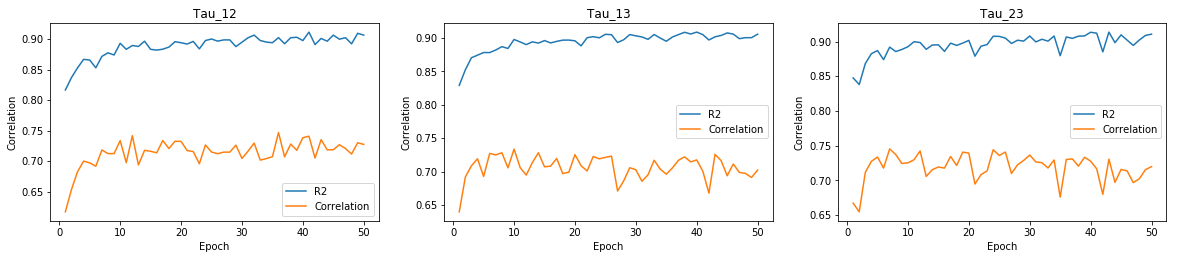

In [8]:
%%time
activation = tf.nn.relu
size = 3
num_files = 25
initializer = None
regularizer = None
epochs = 50
batch_size = 1000
val_split = 0.2

fig = plt.figure(figsize = (20, 6))
input_shape = (2 * size + 1, 2 * size + 1, 2 * size + 1, 3)

# Create network instance and compile model
neural_net = DNN(activation, initializer, regularizer, input_shape)
model = neural_net.create_model()
model.compile(optimizer = tf.train.AdamOptimizer(), loss = {"tau_12": "mse", 
                                                                                                "tau_13": 'mse', 
                                                                                                "tau_23": "mse"})
correlation = {"Tau_12":[], "Tau_13": [], "Tau_23": []}
R2 = {"Tau_12":[], "Tau_13": [], "Tau_23": []}

for i in range(epochs):
    files_range = np.arange(1, num_files + 1)
    np.random.shuffle(files_range)
    for j in files_range:

        # Load shards
        x = []
        y_tau_12 = []
        y_tau_13 = []
        y_tau_23 = []
        for coarse_folder in os.listdir(path_to_folder + "/Re1243Fr20")[1:]:
            x.append(np.load(path + "/Data_" + coarse_folder + "/Data/" + str(j) + ".npy"))
            y_tau_12.append(np.load(path + "/Data_" + coarse_folder + "/Labels/" + str(j) + ".npy")[0])
            y_tau_13.append(np.load(path + "/Data_" + coarse_folder + "/Labels/" + str(j) + ".npy")[1])
            y_tau_23.append(np.load(path + "/Data_" + coarse_folder + "/Labels/" + str(j) + ".npy")[2])
        
        x = np.concatenate(x, axis = 0)
        y_tau_12 = np.concatenate(y_tau_12, axis = 0)
        y_tau_13 = np.concatenate(y_tau_13, axis = 0)
        y_tau_23 = np.concatenate(y_tau_23, axis = 0)

        # Create train and test data
        mask =  np.random.rand(x.shape[0]) < 0.80
        x_train, x_test = x[mask,:,:,:,:], x[~mask,:,:,:,:]
        tau_12_train, tau_12_test = y_tau_12[mask], y_tau_12[~mask]
        tau_13_train, tau_13_test = y_tau_13[mask], y_tau_13[~mask]
        tau_23_train, tau_23_test = y_tau_23[mask], y_tau_23[~mask]

        del y_tau_12
        del y_tau_13
        del y_tau_23
        gc.collect()

        y_train = [tau_12_train, tau_13_train, tau_23_train]
        y_test = [tau_12_test, tau_13_test, tau_23_test]

        # Fit model on shard
        model.fit(x_train, {"tau_12": y_train[0], 
                                     "tau_13": y_train[1], 
                                     "tau_23": y_train[2]}, 
                        epochs = 1, 
                        batch_size = batch_size, 
                        validation_split = val_split,
                        verbose = 0)
        del x_train
        del y_train
        gc.collect()

        # Generate predictions on shard
        preds = model.predict(x_test)
        temp_1 = {"Tau_12":[], "Tau_13": [], "Tau_23": []}
        temp_2 = {"Tau_12":[], "Tau_13": [], "Tau_23": []}

        for l in range(len(preds)):
            temp_1[list(temp_1.keys())[l]].append(r2_score(y_test[l], preds[l].flatten()))
            temp_2[list(temp_2.keys())[l]].append(np.corrcoef(y_test[l], preds[l].flatten())[0,1])
        del x_test
        del x
        gc.collect()

    #Get average test corr and R2 for the epoch
    for n in range(len(temp_1)):
        correlation[list(correlation.keys())[n]].append(np.mean(temp_1[list(temp_1.keys())[n]]))
        R2[list(R2.keys())[n]].append(np.mean(temp_2[list(temp_2.keys())[n]]))

# Plot R2 and corr evolution
for k in range(len(temp_1)):
    fig.add_subplot(1, 3, k + 1)
    plt.plot(np.arange(1, epochs + 1), np.array(R2[list(R2.keys())[k]]), label = 'R2')
    plt.plot(np.arange(1, epochs + 1), np.array(correlation[list(correlation.keys())[k]]), label = 'Correlation')
    plt.xlabel('Epoch')
    plt.ylabel("Correlation")
    plt.title(list(correlation.keys())[k])
    plt.legend()

for m in range(len(preds)):
    print("Final Dataset Correlation for " + list(correlation.keys())[m] + ": %.4f" % np.corrcoef(preds[m].flatten(), y_test[m])[0, 1])
del preds
del y_test
del temp_1
del temp_2 
gc.collect()

# Save model to disk
os.chdir(path)
model_name_json = "combined_coarses_model_tau.json"
model_name_h5 = "combined_coarses_model_tau.h5"
model_json = model.to_json()
with open(model_name_json, "w") as json_file:
    json_file.write(model_json)
model.save_weights(model_name_h5)
print("Saved model to disk\n")